# ***Libraries***

In [1]:
!pip install modAL-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, f1_score


from IPython import display
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 42
np.random.seed(RANDOM_STATE_SEED)

# ***Data Overview and Exploration***

Two datasets are provided. The original dataset, in the form provided by Prof. Hofmann, contains categorical/symbolic attributes and is in the file "german.data". In this project, we utilize the original dataset and convert each categorical/symbolic value of a variable to a numerical value using label encoding, or one hot encoding in some scenarios. One hot encoding generaly is the ideal method for converting variable values when no inherent order among the categories exist.

In [42]:
gcd = pd.read_csv('German_Credit_Data.data', delimiter='\s+', header=None)

We can't rename the columns of the numerical version of the dataset.

In [ ]:
gcd = pd.read_fwf('German_Credit_Data.data-numeric', header=None)

In [ ]:
gcd.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Replace the column number with column names (only for the 'German_Credit_Data.data' dataset). The column names are specified in the dataset description.



In [43]:
column_names = [
    'Status of existing checking account',
    'Duration in month',
    'Credit history',
    'Purpose',
    'Credit amount',
    'Savings account/bonds',
    'Present employment since',
    'Installment rate in percentage of disposable income',
    'Personal status and sex',
    'Other debtors / guarantors',
    'Present residence since',
    'Property',
    'Age in years',
    'Other installment plans',
    'Housing',
    'Number of existing credits at this bank',
    'Job',
    'Number of people being liable to provide maintenance for',
    'Telephone',
    'foreign worker',
    'Class'
  ]

In [44]:
columns_mapping = {old_name: new_name for old_name, new_name in zip(gcd.columns, column_names)}

gcd.rename(columns=columns_mapping, inplace=True)

In [ ]:
gcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [ ]:
gcd.dropna().shape

(1000, 21)

In [ ]:
gcd.drop_duplicates().shape

(1000, 21)

There is an imbalance between the classes which we will not address in this notebook.



In [ ]:
gcd['Class'].value_counts()

Class
0    700
1    300
Name: count, dtype: int64

In [45]:
gcd['Class'] = gcd['Class'].replace({1: 0, 2: 1})

In [46]:
gcd_cp = gcd.copy()

We convert the values of the categorical columns to numerical values using the label encoder.

In [47]:
categorical_columns = gcd_cp.select_dtypes(include=['object']).columns

In [48]:
label_encoder = LabelEncoder()
#gcd_cp = pd.get_dummies(gcd_cp, columns=categorical_columns)

for col in categorical_columns: gcd_cp[col] = label_encoder.fit_transform(gcd_cp[col])

In [ ]:
gcd_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Status of existing checking account                       1000 non-null   int64
 1   Duration in month                                         1000 non-null   int64
 2   Credit history                                            1000 non-null   int64
 3   Purpose                                                   1000 non-null   int64
 4   Credit amount                                             1000 non-null   int64
 5   Savings account/bonds                                     1000 non-null   int64
 6   Present employment since                                  1000 non-null   int64
 7   Installment rate in percentage of disposable income       1000 non-null   int64
 8   Personal status and sex                

In [49]:
X_gcd = gcd_cp.drop(columns=['Class'])
Y_gcd = gcd_cp['Class']

In [ ]:
X_gcd.isnull().values.any()

False

In [50]:
X_gcd = X_gcd.to_numpy()
Y_gcd = Y_gcd.to_numpy()

In [ ]:
print(X_gcd[0])

In [ ]:
# If one hot encoder is used, use the below code.
for entry in X_gcd:
  for value in range(7, len(entry)):
    if entry[value]:
      entry[value] = 0
    else:
      entry[value] = 1

In [ ]:
print(X_gcd[0])





For visualization purposes, we apply PCA to the original dataset.

In [51]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_gcd = pca.fit_transform(X=X_gcd)

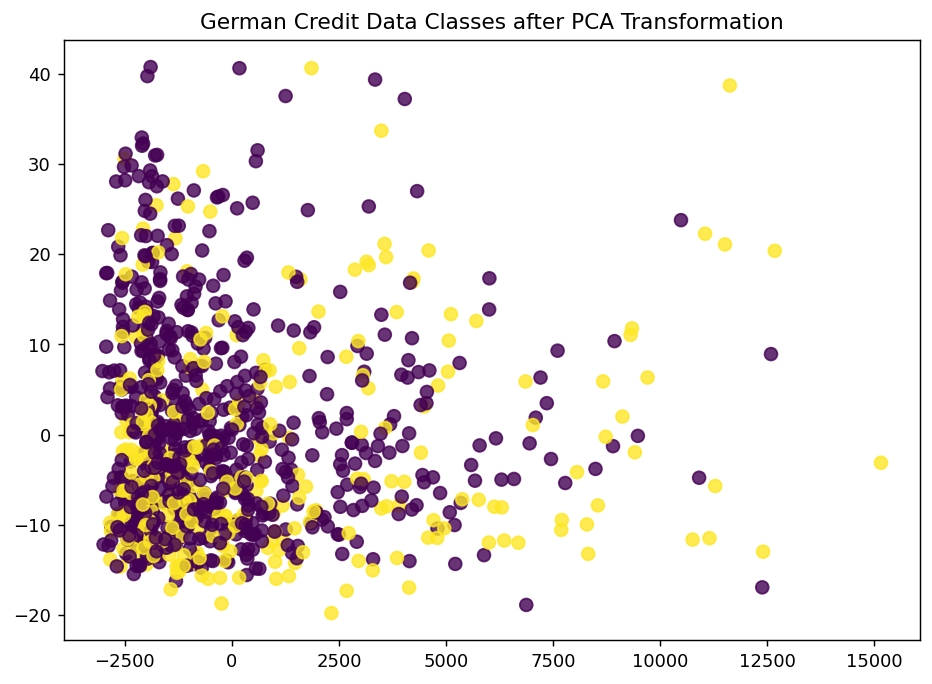

In [52]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_gcd[:, 0], transformed_gcd[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=Y_gcd, cmap='viridis', s=50, alpha=8/10)
plt.title('German Credit Data Classes after PCA Transformation')
plt.show()

It becomes obvious from the plot that the points belonging to each class are intermixed. This can happen for two reasons:
- The data samples, in their original form with all columns included (prior to dimensionality reduction), are sufficiently similar that when the dimensions are reduced, the points become intermixed.
- Reducing the initial dimensions causes the points to appear intermixed.

The intermixed points may result in minimal or no performance improvement from the classification process when using uncertainty and random sampling methods. This phenomenon can be attributed to the lack of clear boundaries between classes. When points (in 2D), or data samples in their original form, from different classes are closely intermixed (very similar to one another), it becomes challenging for the classifier to discern and learn the underlying patterns effectively. As a result, the classifier's ability to make accurate predictions is hampered because it cannot easily separate the classes based on the available features. This ambiguity undermines the benefits of advanced sampling strategies like uncertainty sampling, which relies on identifying the most informative points to query. Consequently, the classifier's performance remains stagnant or only slightly improves, as it struggles to gain significant insights from the ambiguously placed points in the dataset.

# ***Active Learning***
**Note**: Class 1 = Good Customer, Class 2 = Bad Customer

The rows represent the actual classification and the columns the predicted classification.

It is worse to categorize a customer as "Good" when they are "Bad" (5), than it is to class a customer as "Bad" when they are "Good" (1).

In [53]:
ORIGINAL_COST = [
    [0,1],
    [5,0]
]

In [ ]:
"""
                          Predicted Good Customer (1)   Predicted Bad Customer (2)
Actual Good Customer (1)           TN                      FP
Actual Bad  Customer (2)           FN                      TP
"""

Class 1 -> 0 |
Class 2 -> 1

In [54]:
class_weights = {0: 1, 1: 5}

We define a custom scorer based on the cost matrix

In [55]:
def cost_sensitive_score(y_true, y_pred):
    total_cost = 0
    for i in range(len(y_true)):
        total_cost += ORIGINAL_COST[y_true[i]][y_pred[i]]
    return total_cost

cost_sensitive_scorer = make_scorer(cost_sensitive_score, cost_matrix=ORIGINAL_COST, greater_is_better=False)

In [56]:
def compute_cost_sensitive_score(learner, X, y):
    predictions = learner.predict(X)
    is_correct = (predictions == y)
    return cost_sensitive_score(y, predictions), is_correct, f1_score(y, predictions, average='weighted')

We split the dataset according to the class imbalance

In [57]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_gcd.shape[0]


sss = StratifiedShuffleSplit(n_splits=1, train_size=100, random_state=RANDOM_STATE_SEED)

for train_index, pool_index in sss.split(X_gcd, Y_gcd):
    X_train = X_gcd[train_index]
    y_train = Y_gcd[train_index]
    X_pool = X_gcd[pool_index]
    y_pool = Y_gcd[pool_index]

train_indices = np.array([np.where((X_gcd == x).all(axis=1))[0][0] for x in X_train])

We further split the pool set to create a test set. The learner take samples from the pool set, removes them, and evaluates its performance on the test set.

In [58]:
# Further split the pool set to create a testing set
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=RANDOM_STATE_SEED)

for pool_index, test_index in sss_test.split(X_pool, y_pool):
    X_pool, X_test = X_pool[pool_index], X_pool[test_index]
    y_pool, y_test = y_pool[pool_index], y_pool[test_index]

In [ ]:
# Uncomment if there is no class imbalance
"""
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=10) # size number of training examples are used

X_train = X_gcd[training_indices]
y_train = Y_gcd[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_gcd, training_indices, axis=0)
y_pool = np.delete(Y_gcd, training_indices, axis=0)
"""

The training and pooling set are stratified.

In [59]:
# For numpy arrays
train_counts = np.bincount(y_train)
pool_counts = np.bincount(y_pool)
test_counts = np.bincount(y_test)

print("Train Counts:")
for value, count in enumerate(train_counts):
    if count > 0:
        print(f"Value {value}: Frequency {count}")

print("\nPool Counts:")
for value, count in enumerate(pool_counts):
    if count > 0:
        print(f"Value {value}: Frequency {count}")

print("\nTest Counts:")
for value, count in enumerate(test_counts):
    if count > 0:
        print(f"Value {value}: Frequency {count}")


Train Counts:
Value 0: Frequency 70
Value 1: Frequency 30

Pool Counts:
Value 0: Frequency 126
Value 1: Frequency 54

Test Counts:
Value 0: Frequency 504
Value 1: Frequency 216


In [ ]:
# Optional (Do not execute)
X_gcd = np.delete(X_gcd, train_indices, axis=0)
Y_gcd = np.delete(Y_gcd, train_indices, axis=0)

In [60]:
transformed_test = pca.fit_transform(X=X_test)

In [61]:
x_component, y_component = transformed_test[:, 0], transformed_test[:, 1]

## **KNN**

KNN for a pre-defined k

In [21]:
# Specify our core estimator along with it's active learning model.
model = KNeighborsClassifier(n_neighbors=5)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [ ]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)
#print(unqueried_score)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

KNN for the optimal k

In [63]:
knn_clfs = {}
for k in range(1, 10):
  model = KNeighborsClassifier(n_neighbors=k)
  learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

  #predictions = learner.predict(X_gcd)
  #is_correct = (predictions == Y_gcd)

  unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'K: {k} Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')
  knn_clfs[k] = [unqueried_score, is_correct]

K: 1 Unqueried score: 901 Correct: 415 Incorrect: 305 F1: 0.5782850406996193
K: 2 Unqueried score: 1045 Correct: 475 Incorrect: 245 F1: 0.5871935831333753
K: 3 Unqueried score: 1016 Correct: 420 Incorrect: 300 F1: 0.5623601649426614
K: 4 Unqueried score: 1040 Correct: 464 Incorrect: 256 F1: 0.5838971838971838
K: 5 Unqueried score: 1021 Correct: 439 Incorrect: 281 F1: 0.5749202037892901
K: 6 Unqueried score: 1061 Correct: 475 Incorrect: 245 F1: 0.5803097787612023
K: 7 Unqueried score: 1007 Correct: 425 Incorrect: 295 F1: 0.5682843375802763
K: 8 Unqueried score: 1013 Correct: 451 Incorrect: 269 F1: 0.5852242975057383
K: 9 Unqueried score: 1025 Correct: 403 Incorrect: 317 F1: 0.5468960087214585


Unqueried Plotting

In [67]:
# Choose the k that exhibits the highest accuracy
model = KNeighborsClassifier(n_neighbors=2)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

unqueried_score = knn_clfs[2][0]
is_correct = knn_clfs[2][1]

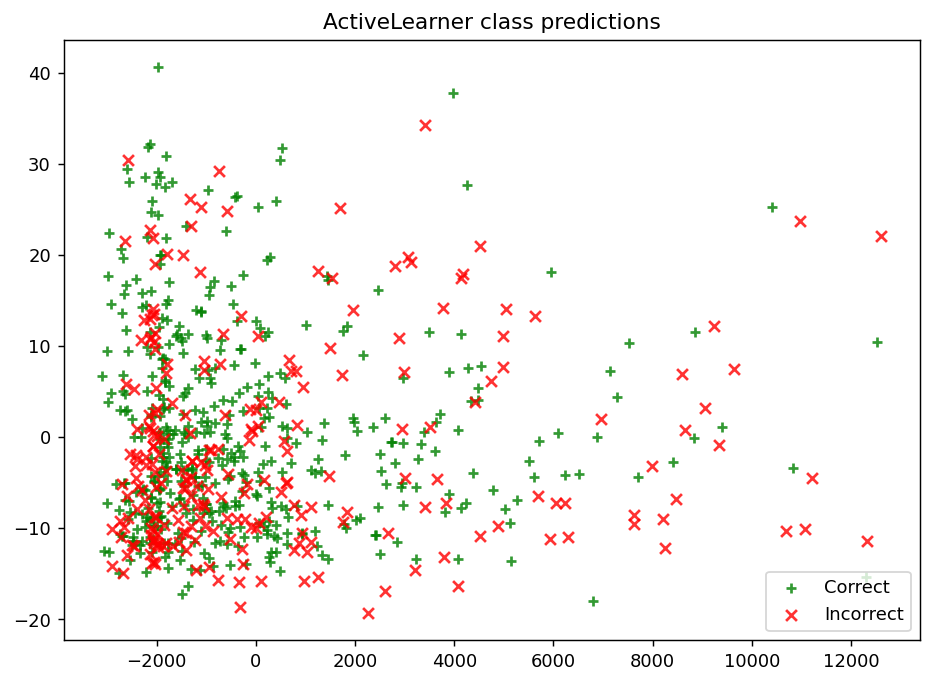

In [65]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [66]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1045 Correct: 475 Incorrect: 245 F1: 0.5871935831333753
Q: 1 Model score: 1045 Correct: 475 Incorrect: 245 F1: 0.5871935831333753
Q: 2 Model score: 1027 Correct: 477 Incorrect: 243 F1: 0.5953846764661868
Q: 3 Model score: 1026 Correct: 478 Incorrect: 242 F1: 0.5962664902803806
Q: 4 Model score: 1018 Correct: 478 Incorrect: 242 F1: 0.5993600853219571
Q: 5 Model score: 1036 Correct: 476 Incorrect: 244 F1: 0.5913300492610837
Q: 6 Model score: 1036 Correct: 476 Incorrect: 244 F1: 0.5913300492610837
Q: 7 Model score: 1068 Correct: 472 Incorrect: 248 F1: 0.5760683760683761
Q: 8 Model score: 1058 Correct: 470 Incorrect: 250 F1: 0.5796134176995754
Q: 9 Model score: 1058 Correct: 470 Incorrect: 250 F1: 0.5796134176995754
Q: 10 Model score: 1058 Correct: 470 Incorrect: 250 F1: 0.5796134176995754
Q: 11 Model score: 1058 Correct: 470 Incorrect: 250 F1: 0.5796134176995754
Q: 12 Model score: 1052 Correct: 468 Incorrect: 252 F1: 0.5812076611920659
Q: 13 Model score: 1052 Correct: 46

Using uncertainty sampling, we observe no significant improvement over 30 queries. The F1-score and the number of correct predictions increase slightly in queries 2-3, while the cost and the number of incorrect predictions decrease the most in comparison to other queries. For the remaining queries, performance remains consistent.

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [68]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1059 Correct: 473 Incorrect: 247 F1: 0.5804137593340677
Q: 1 Model score: 1059 Correct: 473 Incorrect: 247 F1: 0.5804137593340677
Q: 2 Model score: 1059 Correct: 473 Incorrect: 247 F1: 0.5804137593340677
Q: 3 Model score: 1059 Correct: 473 Incorrect: 247 F1: 0.5804137593340677
Q: 4 Model score: 1058 Correct: 474 Incorrect: 246 F1: 0.5812449637389202
Q: 5 Model score: 1055 Correct: 473 Incorrect: 247 F1: 0.5821334373780725
Q: 6 Model score: 1055 Correct: 473 Incorrect: 247 F1: 0.5821334373780725
Q: 7 Model score: 1055 Correct: 473 Incorrect: 247 F1: 0.5821334373780725
Q: 8 Model score: 1050 Correct: 474 Incorrect: 246 F1: 0.584670551322277
Q: 9 Model score: 1050 Correct: 474 Incorrect: 246 F1: 0.584670551322277
Q: 10 Model score: 1049 Correct: 467 Incorrect: 253 F1: 0.581940763528562
Q: 11 Model score: 1049 Correct: 467 Incorrect: 253 F1: 0.581940763528562
Q: 12 Model score: 1049 Correct: 467 Incorrect: 253 F1: 0.581940763528562
Q: 13 Model score: 1049 Correct: 467 Inc

Random sampling results in worse performance for every query compared to uncertainty sampling.

### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## **Random Forests**

Random Forests for the default parameters

In [73]:
# Specify our core estimator along with it's active learning model.
model = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [74]:
# Record our learner's score on the raw data.
unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

Unqueried score: 904 Correct: 516 Incorrect: 204 F1: 0.6622704851474349


Hyper parameter tuning for Random Forests

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid=param_grid, n_jobs=-1, verbose=3, scoring=cost_sensitive_scorer)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters from the random search
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 50}


In [ ]:
# Specify our core estimator along with it's active learning model.
model = RandomForestClassifier(bootstrap=True, max_depth=10, n_estimators=50, random_state=RANDOM_STATE_SEED, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [ ]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

#### Unqueried Plotting

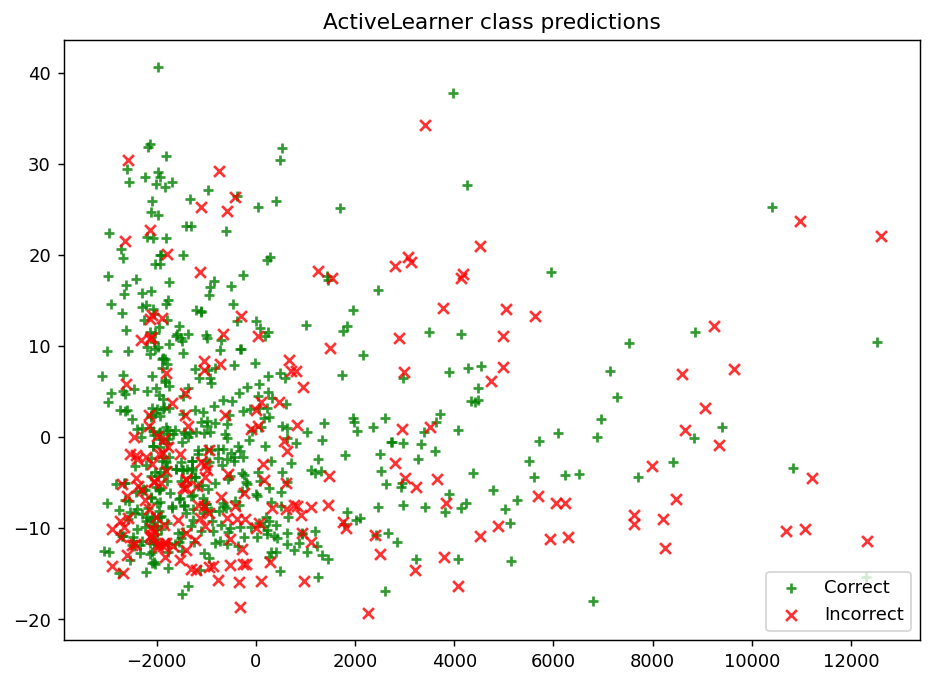

In [71]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [72]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 867 Correct: 521 Incorrect: 199 F1: 0.6771176330231449
Q: 1 Model score: 872 Correct: 520 Incorrect: 200 F1: 0.6749196749196749
Q: 2 Model score: 902 Correct: 518 Incorrect: 202 F1: 0.664301379209513
Q: 3 Model score: 878 Correct: 522 Incorrect: 198 F1: 0.6746506746626687
Q: 4 Model score: 898 Correct: 518 Incorrect: 202 F1: 0.6655815588224601
Q: 5 Model score: 886 Correct: 518 Incorrect: 202 F1: 0.6692950217173405
Q: 6 Model score: 876 Correct: 516 Incorrect: 204 F1: 0.6707368421052631
Q: 7 Model score: 881 Correct: 515 Incorrect: 205 F1: 0.6685475101052588
Q: 8 Model score: 866 Correct: 518 Incorrect: 202 F1: 0.6750846727731934
Q: 9 Model score: 849 Correct: 515 Incorrect: 205 F1: 0.6772063492063491
Q: 10 Model score: 866 Correct: 510 Incorrect: 210 F1: 0.6688124356552138
Q: 11 Model score: 854 Correct: 518 Incorrect: 202 F1: 0.6783350924693682
Q: 12 Model score: 874 Correct: 514 Incorrect: 206 F1: 0.6697739065974798
Q: 13 Model score: 874 Correct: 518 Incorrect: 20

Using uncertainty sampling the last query (29) produces the best results in all metrics

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [75]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 920 Correct: 512 Incorrect: 208 F1: 0.6543301330474194
Q: 1 Model score: 931 Correct: 509 Incorrect: 211 F1: 0.6486673528163185
Q: 2 Model score: 912 Correct: 516 Incorrect: 204 F1: 0.6596626612280895
Q: 3 Model score: 919 Correct: 513 Incorrect: 207 F1: 0.6553276873600851
Q: 4 Model score: 915 Correct: 517 Incorrect: 203 F1: 0.6593259425967603
Q: 5 Model score: 920 Correct: 516 Incorrect: 204 F1: 0.6569645488428535
Q: 6 Model score: 917 Correct: 515 Incorrect: 205 F1: 0.6573251575938271
Q: 7 Model score: 921 Correct: 515 Incorrect: 205 F1: 0.6559695479425411
Q: 8 Model score: 934 Correct: 514 Incorrect: 206 F1: 0.6507818857908378
Q: 9 Model score: 939 Correct: 517 Incorrect: 203 F1: 0.6507677423680758
Q: 10 Model score: 928 Correct: 520 Incorrect: 200 F1: 0.656665478070399
Q: 11 Model score: 932 Correct: 520 Incorrect: 200 F1: 0.6551856643311857
Q: 12 Model score: 946 Correct: 514 Incorrect: 206 F1: 0.6463654424125108
Q: 13 Model score: 945 Correct: 515 Incorrect: 20

With random sampling, no query outperforms those using uncertainty sampling. In fact, there is a notably high difference in performance between queries 28 and 29 when using uncertainty sampling.








### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## **Logistic Regression**

Logistic regression for the default parameters

In [80]:
# Specify our core estimator along with it's active learning model.
model = LogisticRegression(random_state=RANDOM_STATE_SEED, max_iter=10000, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [81]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)
#print(unqueried_score)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

Unqueried score: 471 Correct: 449 Incorrect: 271 F1: 0.6385313575491717


Plotting and Evaluation through Querying

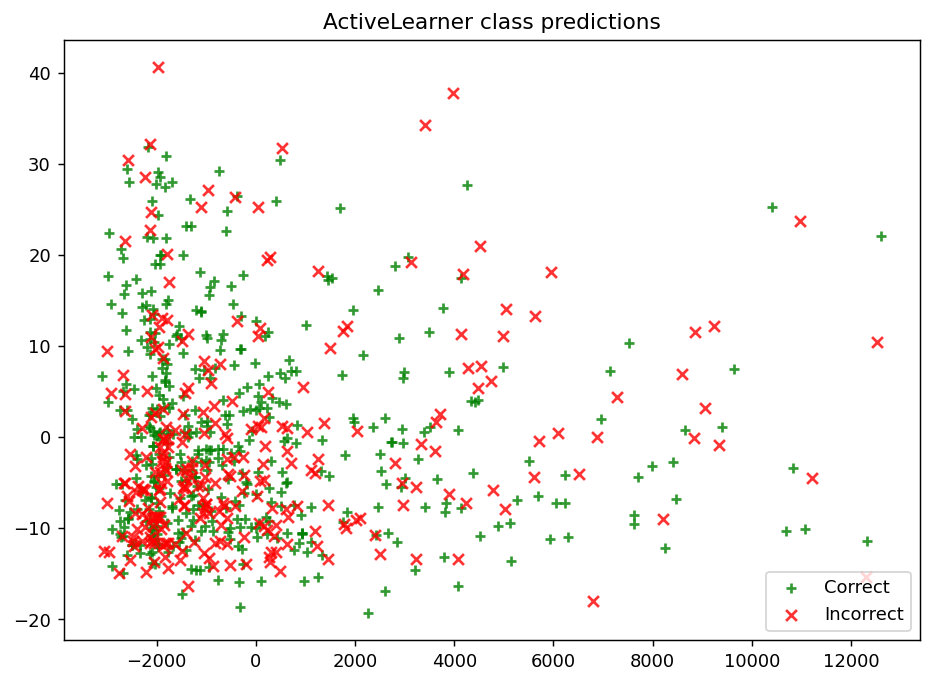

In [78]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [79]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 471 Correct: 425 Incorrect: 295 F1: 0.6036996008510488
Q: 1 Model score: 477 Correct: 427 Incorrect: 293 F1: 0.6069862635587895
Q: 2 Model score: 493 Correct: 427 Incorrect: 293 F1: 0.6077035582822086
Q: 3 Model score: 488 Correct: 432 Incorrect: 288 F1: 0.6147915027537372
Q: 4 Model score: 463 Correct: 433 Incorrect: 287 F1: 0.615218647583936
Q: 5 Model score: 471 Correct: 429 Incorrect: 291 F1: 0.6096689511795487
Q: 6 Model score: 500 Correct: 428 Incorrect: 292 F1: 0.6094413847364281
Q: 7 Model score: 487 Correct: 433 Incorrect: 287 F1: 0.6162031015409317
Q: 8 Model score: 515 Correct: 425 Incorrect: 295 F1: 0.6056527193274398
Q: 9 Model score: 493 Correct: 435 Incorrect: 285 F1: 0.6192886491988376
Q: 10 Model score: 506 Correct: 430 Incorrect: 290 F1: 0.6125434770606747
Q: 11 Model score: 474 Correct: 438 Incorrect: 282 F1: 0.622960810715045
Q: 12 Model score: 483 Correct: 429 Incorrect: 291 F1: 0.6102120447041791
Q: 13 Model score: 475 Correct: 433 Incorrect: 287

In logistic regression, we see improvement in performance in the last queries in terms of the total cost, no correct and incorrect prediction, and F1-score

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [82]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_test, y_test)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_test.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 479 Correct: 445 Incorrect: 275 F1: 0.633097441480675
Q: 1 Model score: 484 Correct: 440 Incorrect: 280 F1: 0.62615050365396
Q: 2 Model score: 496 Correct: 440 Incorrect: 280 F1: 0.6264773915523306
Q: 3 Model score: 497 Correct: 443 Incorrect: 277 F1: 0.6307099228003867
Q: 4 Model score: 483 Correct: 449 Incorrect: 271 F1: 0.6387894394868768
Q: 5 Model score: 494 Correct: 446 Incorrect: 274 F1: 0.6348293520786286
Q: 6 Model score: 503 Correct: 449 Incorrect: 271 F1: 0.63910758900843
Q: 7 Model score: 502 Correct: 450 Incorrect: 270 F1: 0.6404632686174677
Q: 8 Model score: 509 Correct: 435 Incorrect: 285 F1: 0.6197555302617904
Q: 9 Model score: 507 Correct: 437 Incorrect: 283 F1: 0.6225253660015335
Q: 10 Model score: 521 Correct: 435 Incorrect: 285 F1: 0.62004450540834
Q: 11 Model score: 516 Correct: 424 Incorrect: 296 F1: 0.6042425530909692
Q: 12 Model score: 544 Correct: 412 Incorrect: 308 F1: 0.5878772631860313
Q: 13 Model score: 442 Correct: 430 Incorrect: 290 F1: 

Using random sampling, we also observe an improvement in performance in the final queries, and it appears that random sampling produces better results than uncertainty sampling. However, this performance gain is not substantial. Ideally, we would expect uncertainty sampling to perform better, but due to the data samples being intermixed, this outcome is not surprising.

### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Conclusions**
Before using the classifiers with an active learner, we assumed that the performance difference between uncertainty sampling and random sampling would be minimal or non-existent. Our assumption was largely correct. However, if we had to choose the best classifier, we would opt for either Random Forests (RF) or Logistic Regression (LR). RF performed better in terms of the number of correct and incorrect predictions, while LR excelled in terms of total cost.